# Tutorial 6: Visualize results

In [1]:
import os, warnings, torch

import torch.nn as nn
import scanpy as sc
import pandas as pd

from model.nicheTrans_ct import *
from datasets.data_manager_STARmap_PLUS import AD_Mouse

from utils.utils import *
from utils.utils_dataloader import *
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


from palettable.cartocolors.diverging import *
from palettable.scientific.diverging import *

### Load dataset

In [2]:
path = '/home/wzk/ST_code/NicheTrans/2024_NicheTrans_upload_data/2023_nn_AD_mouse/wild_type_adata_protein/spatial_13months-control-replicate_1.h5ad'
rna_adata = sc.read_h5ad(path)

### Load args

In [3]:
%run ./args/args_STARmap_PLUS.py
args = args

### Create dataloader

In [4]:
# create the dataloaders
dataset = AD_Mouse(AD_adata_path=args.AD_adata_path, Wild_type_adata_path=args.Wild_type_adata_path, n_top_genes=args.n_top_genes)
_, _, valloader = ad_mouse_dataloader(args, dataset)

------Calculating spatial graph...
The graph contains 124464 edges, 10372 cells.
12.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 115608 edges, 9634 cells.
12.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 96408 edges, 8034 cells.
12.0000 neighbors per cell on average.
=> AD Mouse loaded
Dataset statistics:
  ------------------------------
  subset   | # num | 
  ------------------------------
  train    |  10372 spots, 894.0 positive tao, 291.0 positive plaque 
  test     |   9634 spots, 620.0 positive tao, 195.0 positive plaque 
  ------------------------------


### Model initialization

In [5]:
# create the model
source_dimension, target_dimension = dataset.rna_length, dataset.target_length
model = NicheTrans_ct(source_length=source_dimension, target_length=target_dimension, noise_rate=args.noise_rate, dropout_rate=args.dropout_rate)
model = nn.DataParallel(model).cuda()

model.load_state_dict(torch.load('NicheTrans_*_STARmap_PLUS.pth'))
model.eval() 

DataParallel(
  (module): NicheTrans_ct(
    (encoder_rna): NetBlock(
      (noise_dropout): Dropout(p=0.5, inplace=False)
      (linear_list): ModuleList(
        (0): Linear(in_features=1719, out_features=512, bias=True)
        (1): Linear(in_features=512, out_features=256, bias=True)
      )
      (bn_list): ModuleList(
        (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_list): ModuleList(
        (0-1): 2 x LeakyReLU(negative_slope=0.01)
      )
      (dropout_list): ModuleList(
        (0): Dropout(p=0.25, inplace=False)
      )
    )
    (projection_rna): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU(inplace=True)
    )
    (fusion_omic): Self_Attention(
      (to_q): Sequential(
        (0): Linear(in_features

### Model inference 

In [6]:
pd_value, gt_value = [], [] 

with torch.no_grad():
    for _, (rna, protein, cell, rna_neighbors, cell_neighbor, _) in enumerate(valloader):

        cell_inf = torch.cat([cell[:, None, :], cell_neighbor], dim=1).cuda()

        rna, protein, rna_neighbors = rna.cuda(), protein.cuda(), rna_neighbors.cuda()
        source, target, source_neightbors = rna, protein, rna_neighbors

        outputs = model(source, source_neightbors, cell_inf)

        pd_value.append(outputs)
        gt_value.append(target)

pd_value = torch.cat(pd_value, dim=0).cpu().numpy()
gt_value = torch.cat(gt_value, dim=0).cpu().numpy()

In [7]:
rna_adata.obs['pd_tau'] = (pd_value[:, 0] > 0.5) * 1
rna_adata.obs['pd_plaque'] = (pd_value[:, 1] > 0.5) * 1

rna_adata.obs['tau'] = (gt_value[:, 0] > 0.5) * 1
rna_adata.obs['plaque'] = (gt_value[:, 1] > 0.5) * 1

### Model evaluation

Text(0.5, 1.0, 'Prediction NicheTrans')

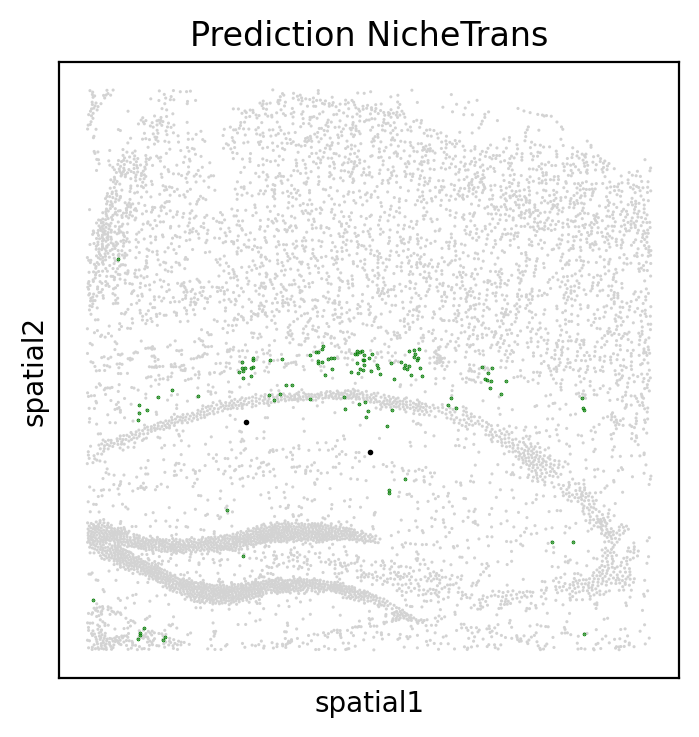

In [8]:
key_pd0, key_gt0 = 'pd_' + dataset.target_panel[0], dataset.target_panel[0]
key_pd1, key_gt1 = 'pd_' + dataset.target_panel[1], dataset.target_panel[1]


fig, ax = plt.subplots(1, figsize=(4, 4), dpi=200)
sc.pl.embedding(rna_adata, basis='spatial', ax=ax, show=False, s=5)

mask = rna_adata.obs[key_pd0] == 1
ax.scatter(rna_adata.obsm['spatial'][mask, 0], rna_adata.obsm['spatial'][mask, 1], color='green',  s=0.1)
mask = rna_adata.obs[key_pd1] == 1
ax.scatter(rna_adata.obsm['spatial'][mask, 0], rna_adata.obsm['spatial'][mask, 1], color='black', s=1)

plt.title('Prediction NicheTrans')

Text(0.5, 1.0, 'Ground Truth')

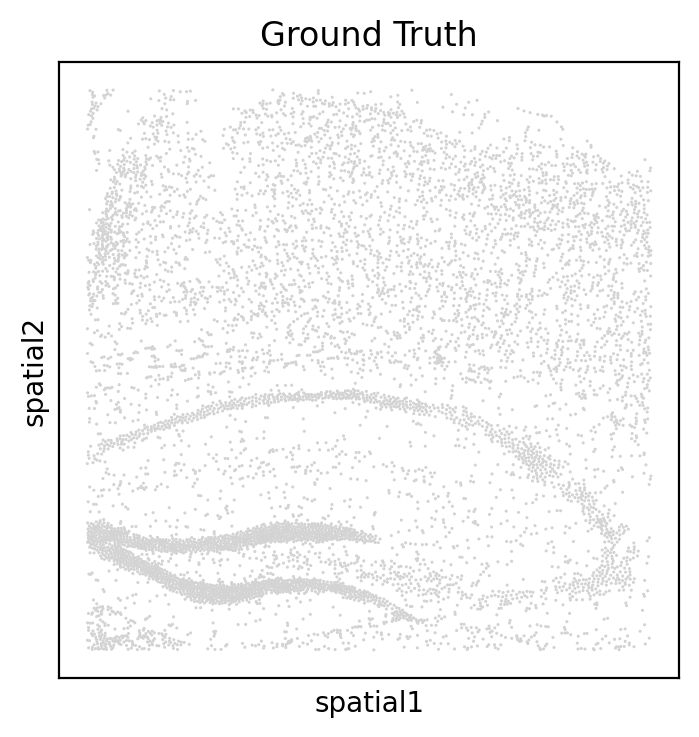

In [9]:
fig, ax = plt.subplots(1, figsize=(4, 4), dpi=200)
sc.pl.embedding(rna_adata, basis='spatial', ax=ax, show=False, s=5)

mask = rna_adata.obs[key_gt0] == 1
ax.scatter(rna_adata.obsm['spatial'][mask, 0], rna_adata.obsm['spatial'][mask, 1], color='green',  s=0.1)
mask = rna_adata.obs[key_gt1] == 1
ax.scatter(rna_adata.obsm['spatial'][mask, 0], rna_adata.obsm['spatial'][mask, 1], color='black', s=1)

plt.title('Ground Truth')